In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kc1-csvsdmlp/kc1_csv.csv


In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.decomposition import PCA as sklearnPCA

# Supress unnecessary warnings so that presentation looks clean
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("../input/kc1-csvsdmlp/kc1_csv.csv")
df.head(2)

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,1.1,1.4,1.4,1.4,1.3,1.3,1.3,1.3,1.3,1.3,...,2,2,2,2,1.2,1.2,1.2,1.2,1.4,False
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1,1,1,1,1.0,1.0,1.0,1.0,1.0,True


<AxesSubplot:xlabel='defects', ylabel='count'>

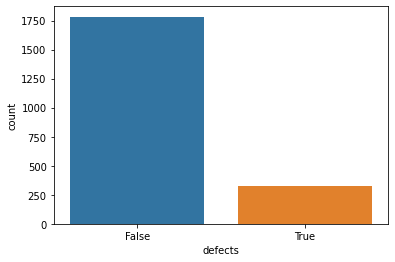

In [4]:
sns.countplot(df['defects'],label="Count")

Text(0.5, 1.05, 'Correlation of Software Defects KC1-Data Features')

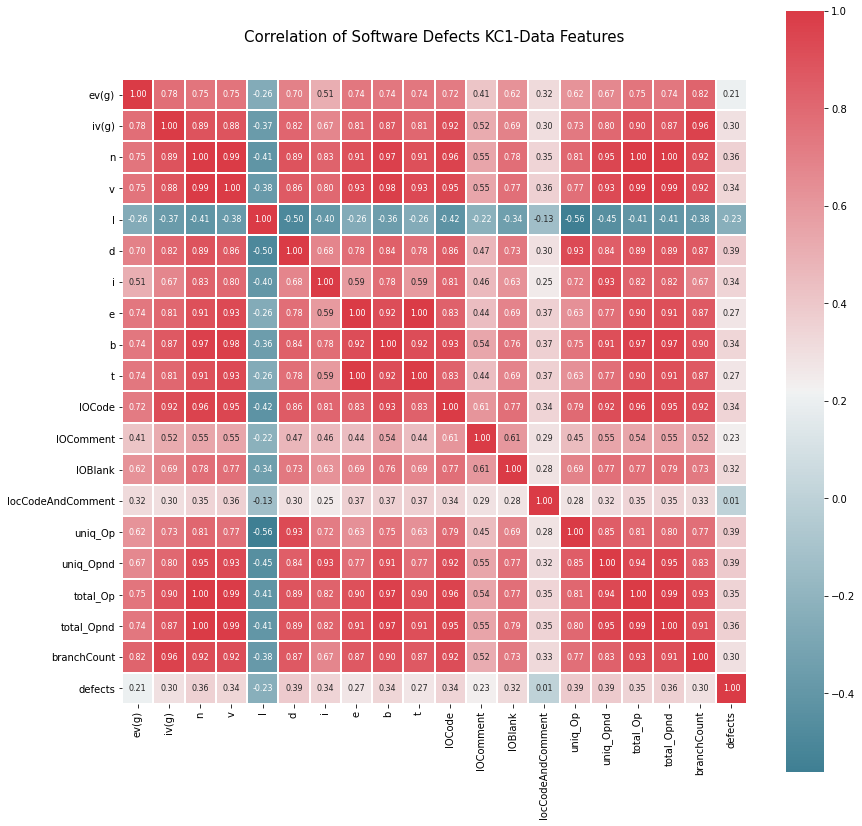

In [5]:
corr = df.iloc[:,2:].corr()
colormap = sns.diverging_palette(220, 10, as_cmap = True)
plt.figure(figsize=(14,14))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 8},
            cmap = colormap, linewidths=0.1, linecolor='white')
plt.title('Correlation of Software Defects KC1-Data Features', y=1.05, size=15)

In [6]:
train,test = train_test_split(df, test_size=0.3, random_state=5)
print("Training Data :",train.shape)
print("Testing Data :",test.shape)

Training Data : (1476, 22)
Testing Data : (633, 22)


In [7]:
train_data = train.iloc[:,:]
test_data = test.iloc[:,:]

print("Training Data :",train_data.shape)
print("Testing Data :",test_data.shape)

Training Data : (1476, 22)
Testing Data : (633, 22)


In [8]:
# Training Data
train_x = train_data.iloc[:,:-1]
train_x = MinMaxScaler().fit_transform(train_x)
print("Training Data :", train_x.shape)

# Testing Data
test_x = test_data.iloc[:,:-1]
test_x = MinMaxScaler().fit_transform(test_x)
print("Testing Data :", test_x.shape)

Training Data : (1476, 21)
Testing Data : (633, 21)


In [9]:
# Training Data
train_y = train_data.iloc[:,-1:]
train_y[train_y==False] = 0
train_y[train_y==True] = 1
print("Training Data :", train_y.shape)

# Testing Data
test_y = test_data.iloc[:,-1:]
test_y[test_y==False] = 0
test_y[test_y==True] = 1
print("Testing Data :", test_y.shape)

Training Data : (1476, 1)
Testing Data : (633, 1)


In [10]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [11]:
X = tf.placeholder(tf.float32, [None,21])
Y = tf.placeholder(tf.float32, [None, 1])

In [12]:
def ann_mlp():
    print("===========Data Summary===========")
    print("Training Data :", train_x.shape)
    print("Testing Data :", test_x.shape)

    X = tf.placeholder(tf.float32, [None,21])
    Y = tf.placeholder(tf.float32, [None, 1])

    # input
    W1 = tf.Variable(tf.random_normal([21,30], seed=0), name='weight1')
    b1 = tf.Variable(tf.random_normal([30], seed=0), name='bias1')
    layer1 = tf.nn.sigmoid(tf.matmul(X,W1) + b1)

    # hidden1
    W2 = tf.Variable(tf.random_normal([30,60], seed=0), name='weight2')
    b2 = tf.Variable(tf.random_normal([60], seed=0), name='bias2')
    layer2 = tf.nn.sigmoid(tf.matmul(layer1,W2) + b2)

    # hidden2
    W3 = tf.Variable(tf.random_normal([60,60], seed=0), name='weight3')
    b3 = tf.Variable(tf.random_normal([60], seed=0), name='bias3')
    layer3 = tf.nn.sigmoid(tf.matmul(layer2,W3) + b3)

    # output
    W4 = tf.Variable(tf.random_normal([60,1], seed=0), name='weight4')
    b4 = tf.Variable(tf.random_normal([1], seed=0), name='bias4')
    logits = tf.matmul(layer3,W4) + b4
    hypothesis = tf.nn.sigmoid(logits)

    cost_i = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=Y)
    cost = tf.reduce_mean(cost_i)

    train = tf.train.MomentumOptimizer(momentum=0.5,learning_rate=0.001).minimize(cost)

    prediction = tf.cast(hypothesis > 0.5, dtype=tf.float32)
    correct_prediction = tf.equal(prediction, Y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, dtype=tf.float32))

    print("\n============Processing============")
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for step in range(20001):
            sess.run(train, feed_dict={X: train_x, Y: train_y})
            if step % 1000 == 0:
                loss, acc = sess.run([cost, accuracy], feed_dict={X: train_x, Y: train_y})
                print("Step: {:5}\tLoss: {:.3f}\tAcc: {:.2%}".format(step, loss, acc))

        train_acc = sess.run(accuracy, feed_dict={X: train_x, Y: train_y})
        test_acc,test_predict,test_correct = sess.run([accuracy,prediction,correct_prediction], feed_dict={X: test_x, Y: test_y})
        
        print("\n============Results============")
        print("Model Prediction =", train_acc)
        print("Test Prediction =", test_acc)
        
        return train_acc,test_acc, test_predict
    
ann_mlp_train_acc, ann_mlp_test_acc, test_predict = ann_mlp()


===========Data Summary===========
Training Data : (1476, 21)
Testing Data : (633, 21)

============Processing============
Step:     0	Loss: 1.918	Acc: 16.12%
Step:  1000	Loss: 0.408	Acc: 83.33%
Step:  2000	Loss: 0.399	Acc: 83.40%
Step:  3000	Loss: 0.393	Acc: 83.33%
Step:  4000	Loss: 0.390	Acc: 83.27%
Step:  5000	Loss: 0.387	Acc: 83.33%
Step:  6000	Loss: 0.384	Acc: 83.27%
Step:  7000	Loss: 0.382	Acc: 83.33%
Step:  8000	Loss: 0.381	Acc: 83.40%
Step:  9000	Loss: 0.379	Acc: 83.54%
Step: 10000	Loss: 0.378	Acc: 83.74%
Step: 11000	Loss: 0.376	Acc: 83.81%
Step: 12000	Loss: 0.375	Acc: 83.67%
Step: 13000	Loss: 0.374	Acc: 83.67%
Step: 14000	Loss: 0.373	Acc: 83.60%
Step: 15000	Loss: 0.372	Acc: 83.81%
Step: 16000	Loss: 0.372	Acc: 83.81%
Step: 17000	Loss: 0.371	Acc: 84.08%
Step: 18000	Loss: 0.370	Acc: 84.08%
Step: 19000	Loss: 0.369	Acc: 84.15%
Step: 20000	Loss: 0.369	Acc: 84.21%

============Results============
Model Prediction = 0.8421409
Test Prediction = 0.8720379


In [13]:
test_predict_2 =[]
for i in range(len(test_predict)):
    test_predict_2.append(int(test_predict[i][0]))
y = np.array(test_y['defects'])
y_ = test_predict_2

con = tf.confusion_matrix(labels=y_, predictions=y )
sess = tf.Session()
with sess.as_default():
        print(sess.run(con))

[[538  74]
 [  7  14]]


In [14]:
y_test = y

In [15]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(633)]
lr_probs = test_predict_2
# keep probabilities for the positive outcome only
#lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, test_predict_2)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('PCA-MLP: ROC AUC=%.3f' % (lr_auc))

No Skill: ROC AUC=0.500
PCA-MLP: ROC AUC=0.573


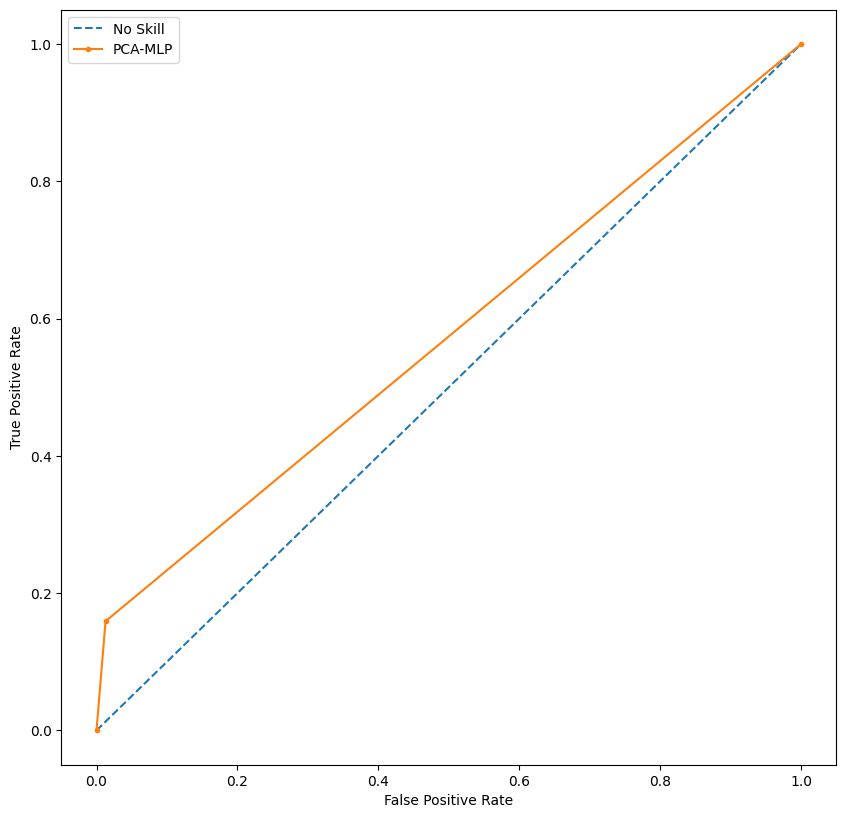

PCA-MLLP: f1=0.257 auc=0.471


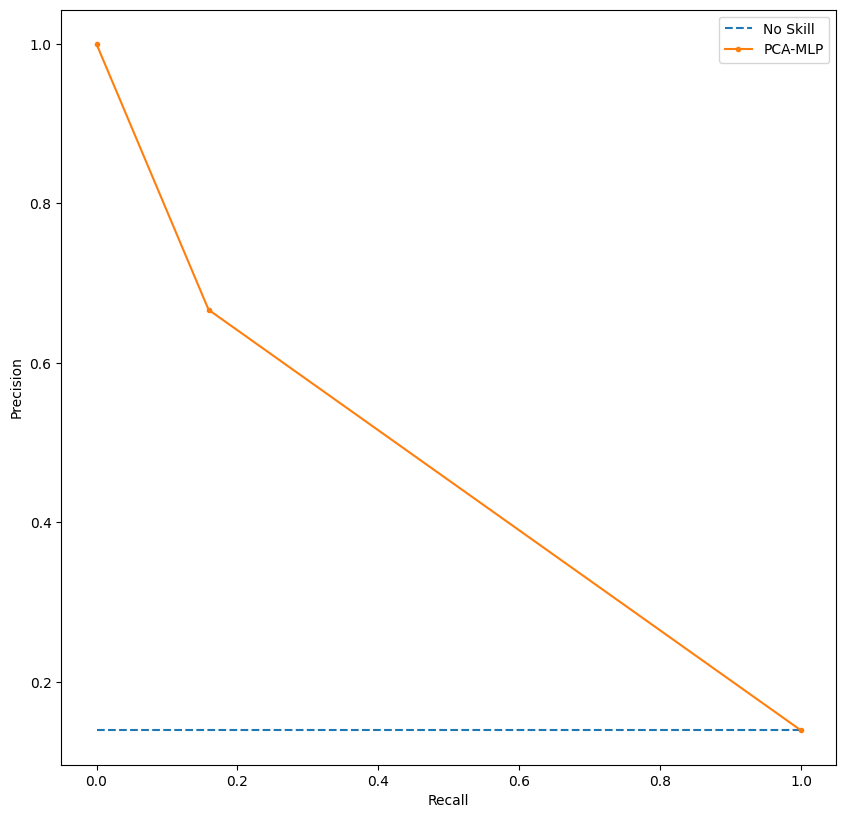

              precision    recall  f1-score   support

         0.0       0.88      0.99      0.93       545
         1.0       0.67      0.16      0.26        88

    accuracy                           0.87       633
   macro avg       0.77      0.57      0.59       633
weighted avg       0.85      0.87      0.84       633



In [16]:
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.figure(figsize=(10,10), dpi=100)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='PCA-MLP')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
# calculate precision and recall for each threshold
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
# calculate precision and recall for each threshold
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
# calculate scores
lr_f1, lr_auc = f1_score(y_test, test_predict_2), auc(lr_recall, lr_precision)
# summarize scores
print('PCA-MLLP: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)

pyplot.figure(figsize=(10,10), dpi=100)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='PCA-MLP')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

print(classification_report(y_test, test_predict_2))